In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [3]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

In [4]:
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()

In [5]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [6]:
df_np_pass,  df_np_other = split(df_non_penalty)

In [7]:
df_np_pass = pd.get_dummies(df_np_pass, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other = pd.get_dummies(df_np_other, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
df_p = pd.get_dummies(df_penalty, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_np_pass = df_np_pass['goal']
x_np_pass = df_np_pass.drop(['goal'], axis=1)
x_npp_train, x_npp_test, y_npp_train, y_npp_test = train_test_split(x_np_pass, y_np_pass, test_size=0.2, random_state=42,
                                                                    stratify=y_np_pass)
y_np_other = df_np_other['goal']
x_np_other = df_np_other.drop(['goal'], axis=1)
x_npo_train, x_npo_test, y_npo_train, y_npo_test = train_test_split(x_np_other, y_np_other, test_size=0.2, random_state=42,
                                                                   stratify=y_np_other)
y_p = df_p['goal']
x_p = df_p.drop(['goal'], axis=1)
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p, y_p, test_size=0.2, random_state=42, stratify=y_p)

In [8]:
print('Shots pass train', len(y_npp_train), ';Number goals', y_npp_train.sum(),
      ';Goals %: ', round(y_npp_train.mean()*100, 1))
print('Shots pass test', len(y_npp_test), ';Number goals', y_npp_test.sum(),
      ';Goals %: ', round(y_npp_test.mean()*100, 1))

Shots pass train 35198 ;Number goals 3860 ;Goals %:  11.0
Shots pass test 8800 ;Number goals 965 ;Goals %:  11.0


In [9]:
print('Shots other train', len(y_npo_train), ';Number goals', y_npo_train.sum(),
      ';Goals %: ', round(y_npo_train.mean()*100, 1))
print('Shots other test', len(y_npo_test), ';Number goals', y_npo_test.sum(),
      ';Goals %: ', round(y_npo_test.mean()*100, 1))

Shots other train 16406 ;Number goals 1618 ;Goals %:  9.9
Shots other test 4102 ;Number goals 404 ;Goals %:  9.8


In [10]:
print('Shots penalty train', len(y_p_train), ';Number goals', y_p_train.sum(),
      ';Goals %: ', round(y_p_train.mean()*100, 1))
print('Shots penalty test', len(y_p_test), ';Number goals', y_p_test.sum(),
      ';Goals %: ', round(y_p_test.mean()*100, 1))

Shots penalty train 656 ;Number goals 486 ;Goals %:  74.1
Shots penalty test 165 ;Number goals 122 ;Goals %:  73.9


In [11]:
logreg = LogisticRegression(solver='sag', n_jobs=-1, max_iter=100, random_state=42)
rfe_npp = RFE(logreg, 24)
rfe_npp = rfe_npp.fit(x_npp_train, y_npp_train)

x_npp_train = x_npp_train.loc[:, rfe_npp.support_]
x_npp_test = x_npp_test.loc[:, rfe_npp.support_]

In [12]:
sc = StandardScaler()
x_npp_train_sc = sc.fit_transform(x_npp_train)
x_npp_test_sc = sc.fit_transform(x_npp_test)

In [13]:
lr = LogisticRegression(random_state=42, solver='sag', max_iter=100)

In [14]:
grid={"C": np.logspace(-3,3,7)}

In [15]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc.astype(float))

In [16]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2895
The ROC AUC of our non-penalty pass model on the training set is : 0.7843
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [17]:
rfe_npo = RFE(logreg, 24)
rfe_npo = rfe_npo.fit(x_npo_train, y_npo_train)

x_npo_train = x_npo_train.loc[:, rfe_npo.support_]
x_npo_test = x_npo_test.loc[:, rfe_npo.support_]

In [18]:
sc = StandardScaler()
x_npo_train_sc = sc.fit_transform(x_npo_train)
x_npo_test_sc = sc.fit_transform(x_npo_test)

In [19]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npo.fit(x_npo_train_sc, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc.astype(float))

In [20]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2595
The ROC AUC of our non-penalty other model on the training set is : 0.8061
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [21]:
rfe_p = RFE(logreg, 10)
rfe_p = rfe_p.fit(x_p_train, y_p_train)

x_p_train = x_p_train.loc[:, rfe_p.support_]
x_p_test = x_p_test.loc[:, rfe_p.support_]

In [22]:
sc = StandardScaler()
x_p_train_sc = sc.fit_transform(x_p_train)
x_p_test_sc = sc.fit_transform(x_p_test)

In [23]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_p.fit(x_p_train_sc, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc.astype(float))

In [24]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5708
The ROC AUC of our penalty model on the training set is : 0.5789
McFadden's Pseudo R-squared penaltys : 0.0025


In [25]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
rfe_npp2 = RFE(logreg, 20)
rfe_npp2 = rfe_npp2.fit(x_npp_train, y_npp_train)

x_npp_train2 = x_npp_train.loc[:, rfe_npp2.support_]
x_npp_test2 = x_npp_test.loc[:, rfe_npp2.support_]

In [26]:
sc = StandardScaler()
x_npp_train_sc2 = sc.fit_transform(x_npp_train2)
x_npp_test_sc2 = sc.fit_transform(x_npp_test2)

In [27]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc2, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc2.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc2.astype(float))

In [28]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2897
The ROC AUC of our non-penalty pass model on the training set is : 0.7841
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [29]:
freg=f_regression(x_npp_train_sc2, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.017 0.067 0.    0.    0.002 0.    0.    0.005 0.006 0.009 0.
 0.54  0.088 0.001 0.256 0.383 0.    0.    0.037]


In [30]:
rfe_npo2 = RFE(logreg, 20)
rfe_npo2 = rfe_npo2.fit(x_npo_train, y_npo_train)

x_npo_train2 = x_npo_train.loc[:, rfe_npo2.support_]
x_npo_test2 = x_npo_test.loc[:, rfe_npo2.support_]

In [31]:
sc = StandardScaler()
x_npo_train_sc2 = sc.fit_transform(x_npo_train2)
x_npo_test_sc2 = sc.fit_transform(x_npo_test2)

In [32]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npo.fit(x_npo_train_sc2, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc2.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc2.astype(float))

In [33]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2597
The ROC AUC of our non-penalty other model on the training set is : 0.8062
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [34]:
rfe_p2 = RFE(logreg, 8)
rfe_p2 = rfe_p2.fit(x_p_train, y_p_train)

x_p_train2 = x_p_train.loc[:, rfe_p2.support_]
x_p_test2 = x_p_test.loc[:, rfe_p2.support_]

In [35]:
sc = StandardScaler()
x_p_train_sc2 = sc.fit_transform(x_p_train2)
x_p_test_sc2 = sc.fit_transform(x_p_test2)

In [36]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_p.fit(x_p_train_sc2, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc2.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc2.astype(float))

In [37]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5709
The ROC AUC of our penalty model on the training set is : 0.5774
McFadden's Pseudo R-squared penaltys : 0.0023


In [38]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
rfe_npp3 = RFE(logreg, 11)
rfe_npp3 = rfe_npp3.fit(x_npp_train, y_npp_train)

x_npp_train3 = x_npp_train.loc[:, rfe_npp3.support_]
x_npp_test3 = x_npp_test.loc[:, rfe_npp3.support_]

In [39]:
sc = StandardScaler()
x_npp_train_sc3 = sc.fit_transform(x_npp_train3)
x_npp_test_sc3 = sc.fit_transform(x_npp_test3)

In [40]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npp.fit(x_npp_train_sc3, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc3.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc3.astype(float))

Wall time: 2.33 s


In [41]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2903
The ROC AUC of our non-penalty pass model on the training set is : 0.7829
McFadden's Pseudo R-squared shots assisted by passes : 0.1604


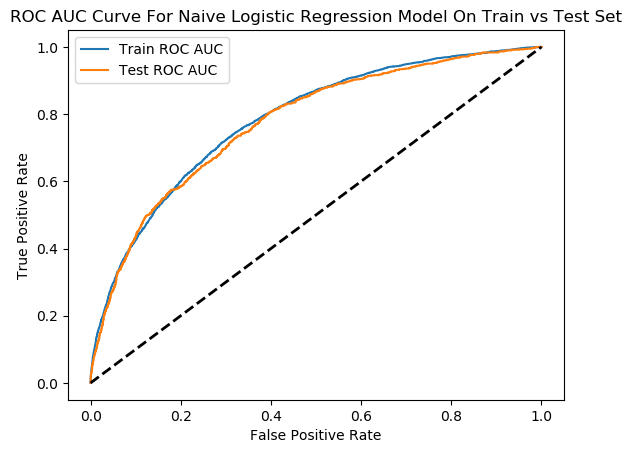

In [42]:
plt.style.use('default')
train_npp_fpr, train_npp_tpr, train_npp_thresholds = roc_curve(y_true=y_npp_train, y_score=train_y_npp_hat[:,1])
test_npp_fpr, test_npp_tpr, test_npp_thresholds = roc_curve(y_true=y_npp_test, y_score=y_pred_lr_npp[:,1])
plt.plot(train_npp_fpr, train_npp_tpr, label = 'Train ROC AUC')
plt.plot(test_npp_fpr, test_npp_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [43]:
freg=f_regression(x_npp_train_sc3, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.067 0.    0.    0.    0.006 0.009 0.088 0.    0.037]


In [44]:
rfe_npo3 = RFE(logreg, 13)
rfe_npo3 = rfe_npo3.fit(x_npo_train, y_npo_train)

x_npo_train3 = x_npo_train.loc[:, rfe_npo3.support_]
x_npo_test3 = x_npo_test.loc[:, rfe_npo3.support_]

In [45]:
sc = StandardScaler()
x_npo_train_sc3 = sc.fit_transform(x_npo_train3)
x_npo_test_sc3 = sc.fit_transform(x_npo_test3)

In [46]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_npo.fit(x_npo_train_sc3, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc3.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc3.astype(float))

Wall time: 1.23 s


In [47]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2602
The ROC AUC of our non-penalty other model on the training set is : 0.8049
McFadden's Pseudo R-squared shots assisted by passes : 0.1604


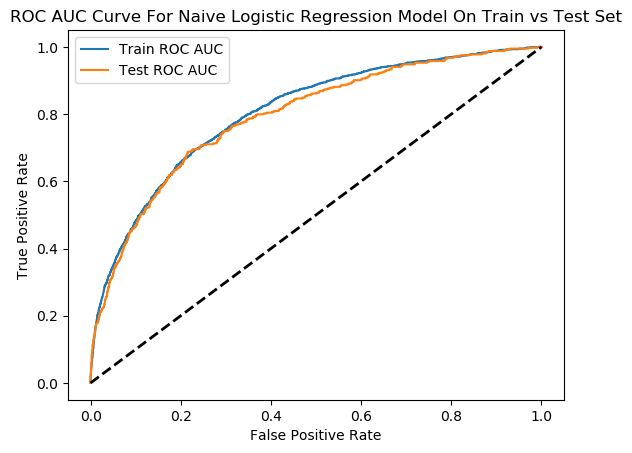

In [48]:
test_y_npo_hat = logistic_regression_npo.predict(x_npo_test3.astype(float))
train_npo_fpr, train_npo_tpr, train_npo_thresholds = roc_curve(y_true=y_npo_train, y_score=train_y_npo_hat[:,1])
test_npo_fpr, test_npo_tpr, test_npo_thresholds = roc_curve(y_true=y_npo_test, y_score=y_pred_lr_npo[:,1])
plt.plot(train_npo_fpr, train_npo_tpr, label = 'Train ROC AUC')
plt.plot(test_npo_fpr, test_npo_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [49]:
freg=f_regression(x_npo_train_sc3, y_npo_train)
p=freg[1]
print(p.round(3))

[0.    0.073 0.    0.    0.    0.    0.029 0.    0.    0.018 0.    0.
 0.891 0.   ]


In [50]:
rfe_p3 = RFE(logreg, 1)
rfe_p3 = rfe_p3.fit(x_p_train, y_p_train)

x_p_train3 = x_p_train.loc[:, rfe_p3.support_]
x_p_test3 = x_p_test.loc[:, rfe_p3.support_]

In [51]:
sc = StandardScaler()
x_p_train_sc3 = sc.fit_transform(x_p_train3)
x_p_test_sc3 = sc.fit_transform(x_p_test3)

In [52]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_p.fit(x_p_train_sc3, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc3.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc3.astype(float))

Wall time: 153 ms


In [53]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5717
The ROC AUC of our penalty model on the training set is : 0.5063
McFadden's Pseudo R-squared penaltys : 0.0008


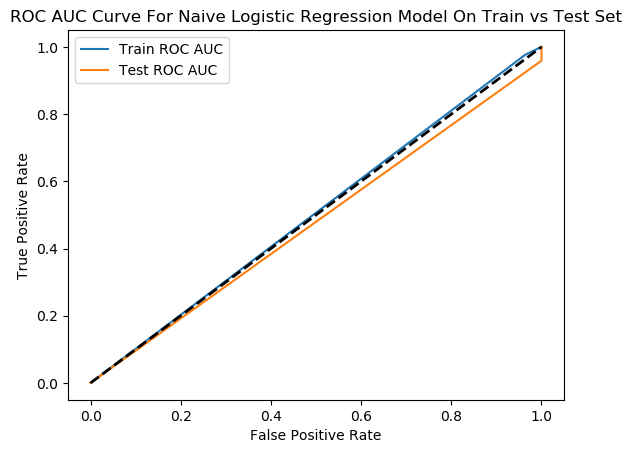

In [54]:
test_y_p_hat = logistic_regression_p.predict(x_p_test3.astype(float))
train_p_fpr, train_p_tpr, train_p_thresholds = roc_curve(y_true=y_p_train, y_score=train_y_p_hat[:,1])
test_p_fpr, test_p_tpr, test_p_thresholds = roc_curve(y_true=y_p_test, y_score=y_pred_lr_p[:,1])
plt.plot(train_p_fpr, train_p_tpr, label = 'Train ROC AUC')
plt.plot(test_p_fpr, test_p_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [55]:
freg=f_regression(x_p_train_sc3, y_p_train)
p=freg[1]
print(p.round(3))

[0.372]


# LightGBM

Load the data

In [56]:
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df2.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty = df2[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df2[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

Split into train, calibration and test datasets

In [57]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train_lgbm, X_penalty_test_lgbm, y_penalty_train_lgbm, y_penalty_test_lgbm = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [58]:
print('Shots train', len(y_train_lgbm), ';Number goals', y_train_lgbm.sum(),
      ';Goals %: ', round(y_train_lgbm.mean()*100, 1))
print('Shots test', len(y_test_lgbm), ';Number goals', y_test_lgbm.sum(),
      ';Goals %: ', round(y_test_lgbm.mean()*100, 1))

Shots train 51604 ;Number goals 5478 ;Goals %:  10.6
Shots test 12902 ;Number goals 1369 ;Goals %:  10.6


In [59]:
print('Penalty Shots train', len(y_penalty_train_lgbm), ';Penalty Number goals', y_penalty_train_lgbm.sum(),
      ';Penalty Goals %: ', round(y_penalty_train_lgbm.mean()*100, 1))
print('Penalty Shots test', len(y_penalty_test_lgbm), ';Penalty Number goals', y_penalty_test_lgbm.sum(),
      ';Penalty Goals %: ', round(y_penalty_test_lgbm.mean()*100, 1))

Penalty Shots train 656 ;Penalty Number goals 486 ;Penalty Goals %:  74.1
Penalty Shots test 165 ;Penalty Number goals 122 ;Penalty Goals %:  73.9


Load and split fake data

In [60]:
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [61]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  3.4


Add fake training data. I am not adding this to the test data as want this to be realistic of real data.

In [62]:
X_train_lgbm = pd.concat([X_train_lgbm, X_fake])
y_train_lgbm = pd.concat([y_train_lgbm, y_fake])

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [63]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train_lgbm = clean_lightgbm(X_train_lgbm)
X_test_lgbm = clean_lightgbm(X_test_lgbm)

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [64]:
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train_lgbm = clean_lightgbm_p(X_penalty_train_lgbm)
X_penalty_test_lgbm = clean_lightgbm_p(X_penalty_test_lgbm)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [65]:
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)
lgbm_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [66]:
searchcv_lgbm = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
%time searchcv_lgbm.fit(X_train_lgbm, y_train_lgbm)
y_pred_lgbm = searchcv_lgbm.best_estimator_.predict_proba(X_test_lgbm)

Wall time: 25min 59s


Permutation importance

In [67]:
perm_result = permutation_importance(searchcv_lgbm.best_estimator_, X_train_lgbm, y_train_lgbm, n_repeats=10, random_state=42)
df_perm_importance = pd.DataFrame({'Feature':X_train_lgbm.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,visible_angle,6.820774e-03,0.000221
1,distance_to_goal,6.396852e-03,0.000168
2,x,1.393430e-03,0.000151
3,body_part_name,1.062657e-03,0.000178
4,n_angle,8.991712e-04,0.000159
5,goalkeeper_x,8.326363e-04,0.000108
6,y,7.832104e-04,0.000149
7,shot_type_name,7.223785e-04,0.000135
8,area_shot,6.330317e-04,0.000133
9,goalkeeper_y,5.341799e-04,0.000079


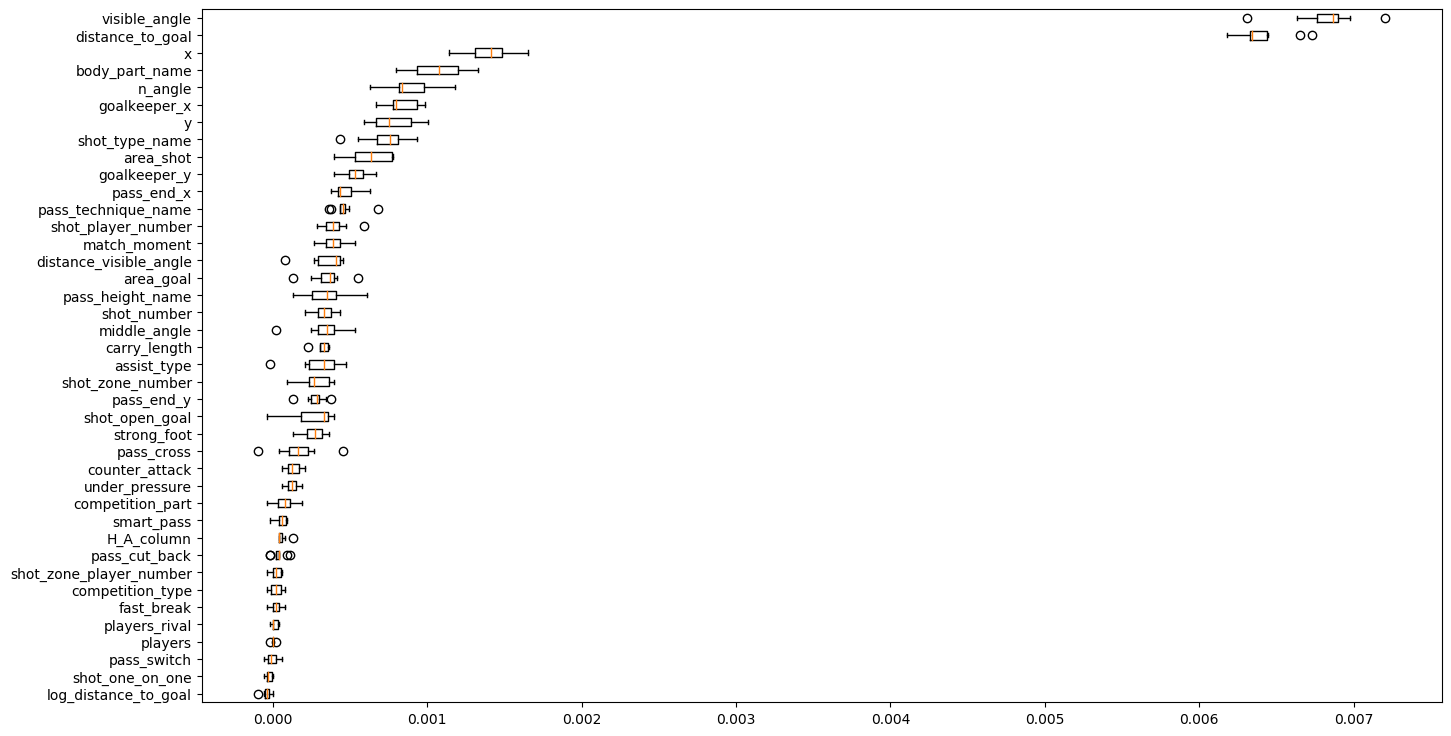

In [68]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train_lgbm.columns[sorted_idx])

Same proces for penalties

In [69]:
searchcv_lgbm_p = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
%time searchcv_lgbm_p.fit(X_penalty_train_lgbm, y_penalty_train_lgbm)
y_pred_lgbm_p = searchcv_lgbm_p.best_estimator_.predict_proba(X_penalty_test_lgbm)

Wall time: 4min 56s


In [70]:
perm_result_p = permutation_importance(searchcv_lgbm_p.best_estimator_, X_penalty_train_lgbm, y_penalty_train_lgbm,
                                       n_repeats=10, random_state=42)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train_lgbm.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

,Feature,importance,std_dev
0,competition_type,0.0,0.0
1,competition_part,0.0,0.0
2,H_A_column,0.0,0.0
3,match_moment,0.0,0.0
4,shot_number,0.0,0.0
5,shot_player_number,0.0,0.0
6,players,0.0,0.0
7,players_rival,0.0,0.0


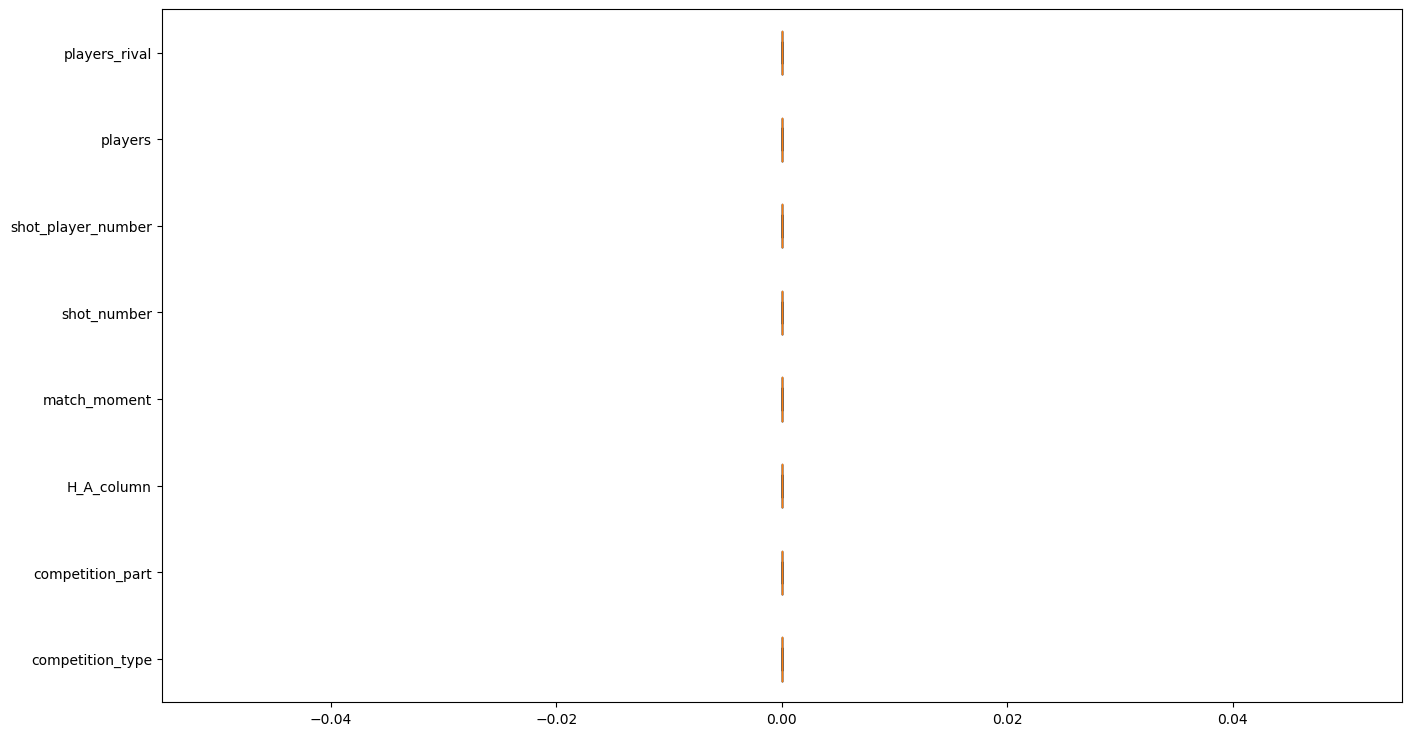

In [71]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train_lgbm.columns[sorted_idx])

# XGBoost

Same process of splitting, adding data fake and cleaning of the LightGBM model.

In [72]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df3.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df3.shot_type_name=='penalty')
df_penalty = df3[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df3[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [73]:
X_train_xgb, X_test, y_train_xgb, y_test_xgb = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train_xgb, X_penalty_test_xgb, y_penalty_train_xgb, y_penalty_test_xgb = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [74]:
X_train_xgb = pd.concat([X_train_xgb, X_fake])
y_train_xgb = pd.concat([y_train_xgb, y_fake])

In [75]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train_xgb = clean_lightgbm(X_train_xgb)
X_test = clean_lightgbm(X_test)

In [76]:
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train_xgb = clean_lightgbm_p(X_penalty_train_xgb)
X_penalty_test_xgb = clean_lightgbm_p(X_penalty_test_xgb)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [77]:
xgb = CalibratedClassifierCV(XGBClassifier(random_state=42, eval_metric='logloss'), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_weight': Integer(0, 50),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 10)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [78]:
searchcv_xgb = BayesSearchCV(estimator=xgb,
                             n_iter=50,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
%time searchcv_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = searchcv_xgb.best_estimator_.predict_proba(X_test)

Wall time: 27min 4s


Permutation importance

In [79]:
perm_result_xgb = permutation_importance(searchcv_xgb.best_estimator_, X_train_xgb, y_train_xgb, n_repeats=10, random_state=42)
df_perm_importance_xgb = pd.DataFrame({'Feature':X_train_xgb.columns,
                                   'importance': perm_result_xgb.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb.importances.std(axis=1)})
df_perm_importance_xgb.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb.reset_index(drop=True, inplace=True)
df_perm_importance_xgb

,Feature,importance,std_dev
0,visible_angle,7.265607e-03,0.000265
1,distance_to_goal,6.666793e-03,0.000175
2,body_part_name,1.370618e-03,0.000183
3,goalkeeper_x,1.353509e-03,0.000103
4,n_angle,1.283172e-03,0.000166
5,shot_type_name,6.767546e-04,0.000172
6,pass_technique_name,4.752490e-04,0.000041
7,distance_visible_angle,4.733480e-04,0.000131
8,area_shot,4.486351e-04,0.000088
9,pass_height_name,4.011102e-04,0.000109


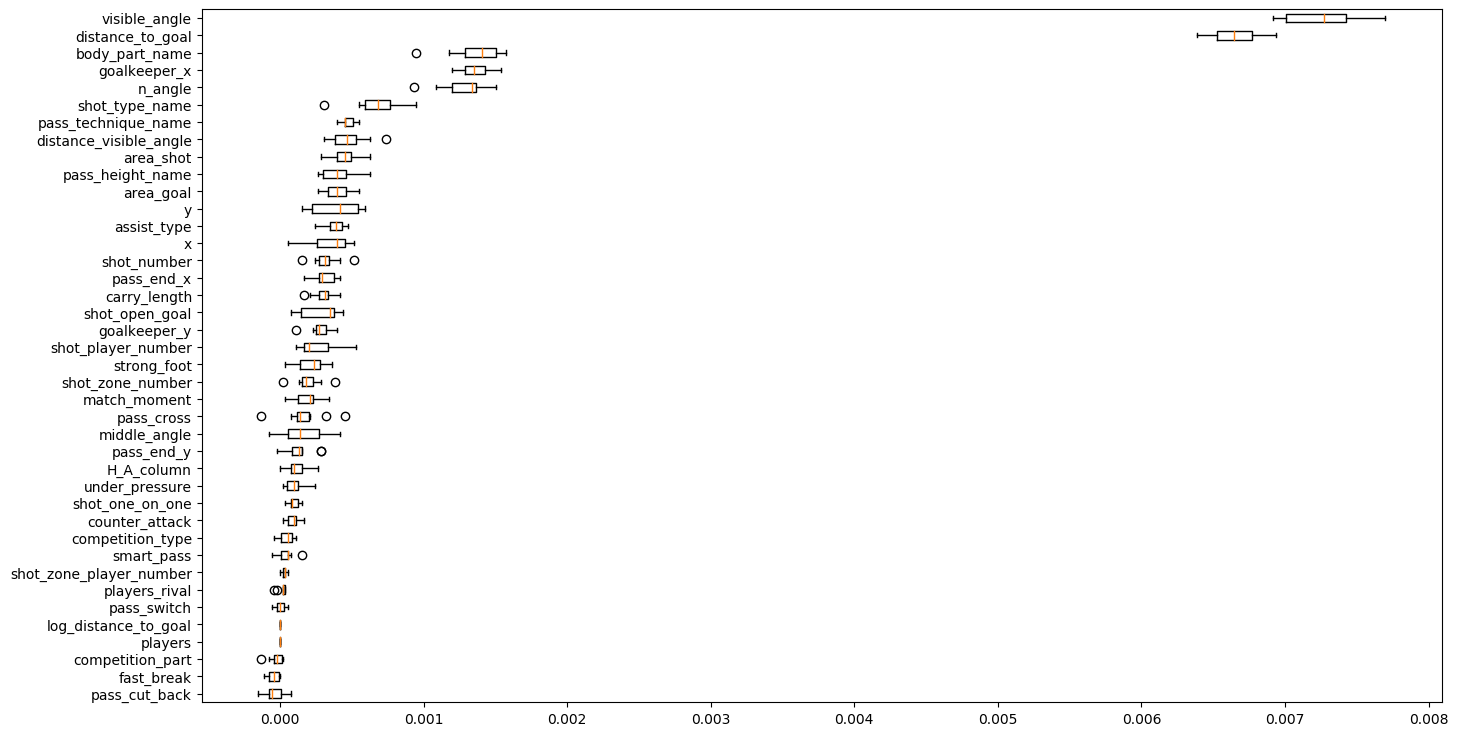

In [80]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb.importances[sorted_idx].T, vert=False, labels=X_train_xgb.columns[sorted_idx])

Same process for penalties

In [82]:
searchcv_xgb_p = BayesSearchCV(estimator=xgb,
                             n_iter=100,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
%time searchcv_xgb_p.fit(X_penalty_train_xgb, y_penalty_train_xgb)
y_pred_xgb_p = searchcv_xgb_p.best_estimator_.predict_proba(X_penalty_test_xgb)

Wall time: 4min 54s


In [83]:
perm_result_xgb_p = permutation_importance(searchcv_xgb_p.best_estimator_, X_penalty_train_xgb, y_penalty_train_xgb,
                                           n_repeats=10, random_state=42)
df_perm_importance_xgb_p = pd.DataFrame({'Feature':X_penalty_train_xgb.columns,
                                   'importance': perm_result_xgb_p.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb_p.importances.std(axis=1)})
df_perm_importance_xgb_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb_p.reset_index(drop=True, inplace=True)
df_perm_importance_xgb_p

,Feature,importance,std_dev
0,shot_number,0.004116,0.004314
1,competition_part,0.002896,0.001067
2,H_A_column,0.000915,0.001011
3,players_rival,0.000610,0.000747
4,competition_type,0.000457,0.000699
5,players,0.000000,0.000000
6,shot_player_number,-0.000610,0.001397
7,match_moment,-0.000762,0.001405


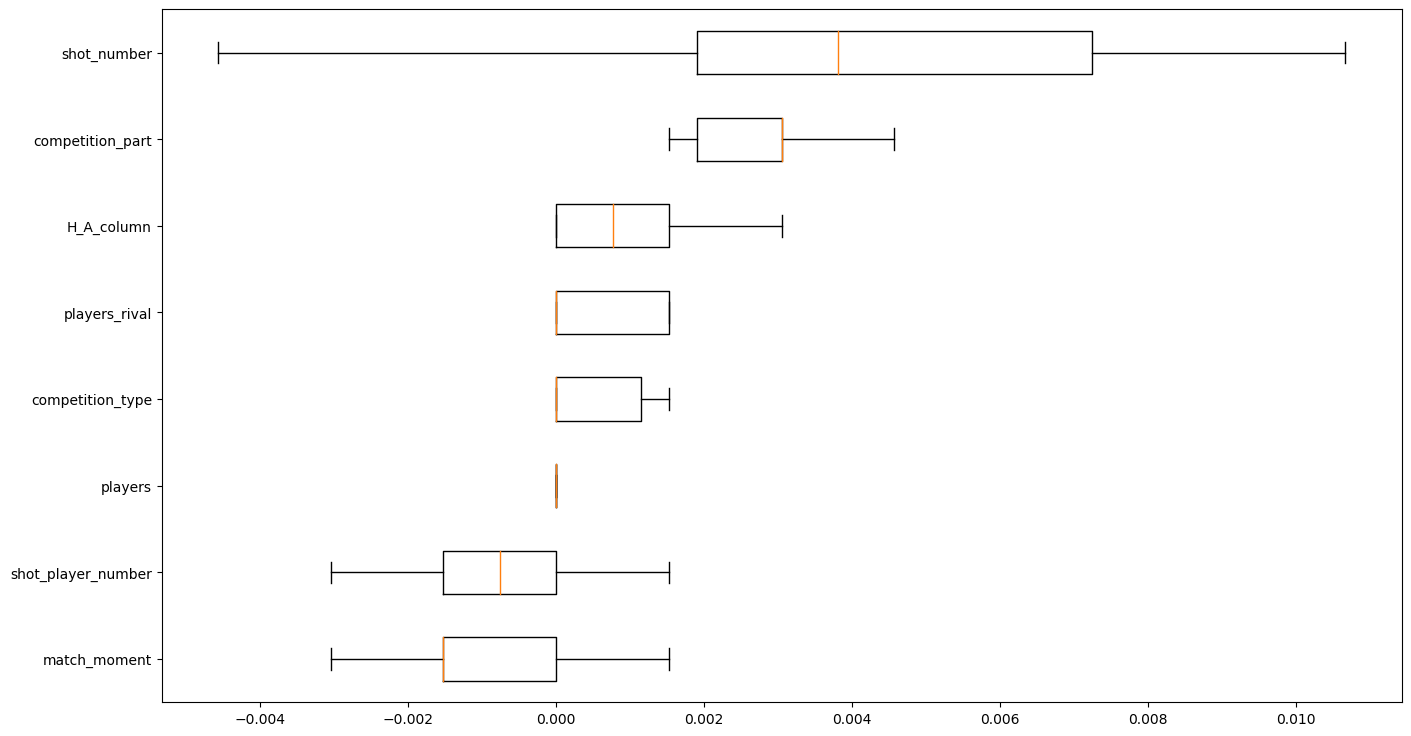

In [84]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train_xgb.columns[sorted_idx])

# Random Forest

Same process of splitting and generation of dummy variables of the Logistic Regression model.

In [ ]:
cwd = os.getcwd()
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df4.shot_type_name=='penalty')
df_penalty_rf = df4[mask_penalty].copy()
df_penalty_rf.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)
df_non_penalty_rf = df4[~mask_penalty].copy()

In [ ]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [ ]:
df_np_pass_rf,  df_np_other_rf = split(df_non_penalty_rf)

In [ ]:
df_np_pass_rf = pd.get_dummies(df_np_pass_rf, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other_rf = pd.get_dummies(df_np_other_rf, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
df_p_rf = pd.get_dummies(df_penalty_rf, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_np_pass_rf = df_np_pass_rf['goal']
x_np_pass_rf = df_np_pass_rf.drop(['goal'], axis=1)
x_npp_train_rf, x_npp_test_rf, y_npp_train_rf, y_npp_test_rf = train_test_split(x_np_pass_rf, y_np_pass_rf, train_size=0.8,
                                                                                random_state=42, stratify=y_np_pass_rf)
y_np_other_rf = df_np_other_rf['goal']
x_np_other_rf = df_np_other_rf.drop(['goal'], axis=1)
x_npo_train_rf, x_npo_test_rf, y_npo_train_rf, y_npo_test_rf = train_test_split(x_np_other_rf, y_np_other_rf, train_size=0.8,
                                                                                random_state=42, stratify=y_np_other_rf)
y_p_rf = df_p_rf['goal']
x_p_rf = df_p_rf.drop(['goal'], axis=1)
x_p_train_rf, x_p_test_rf, y_p_train_rf, y_p_test_rf = train_test_split(x_p_rf, y_p_rf, train_size=0.8, random_state=42,
                                                                    stratify=y_p_rf)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [ ]:
rf = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='isotonic', cv=3)
rf_param_grid = {'base_estimator__n_estimators': [100, 500],
                   'base_estimator__max_features': ['auto'],
                   'base_estimator__min_samples_leaf': [1, 5, 20, 100],
                   'base_estimator__min_samples_split': [2, 10, 50, 250],
                   'base_estimator__criterion': ["gini", "entropy"],
                   'base_estimator__max_depth': [4, 6, 8, 10, None]
}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [ ]:
searchcv_rf_npp = BayesSearchCV(estimator=rf,
                                 n_iter=50,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_npp.fit(x_npp_train_rf, y_npp_train_rf)
y_pred_rf_npp = searchcv_rf_npp.best_estimator_.predict_proba(x_npp_test_rf)

Permutation importance

In [ ]:
perm_result_rf_npp = permutation_importance(searchcv_rf_npp.best_estimator_, x_npp_train_rf, y_npp_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_npp = pd.DataFrame({'Feature':x_npp_train_rf.columns,
                                   'importance': perm_result_rf_npp.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_npp.importances.std(axis=1)})
df_perm_importance_rf_npp.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_npp.reset_index(drop=True, inplace=True)
df_perm_importance_rf_npp

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_npp.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_npp.importances[sorted_idx].T, vert=False, labels=x_npp_train_rf.columns[sorted_idx])

Same process for other shots.

In [ ]:
searchcv_rf_npo = BayesSearchCV(estimator=rf,
                                 n_iter=50,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_npo.fit(x_npo_train_rf, y_npo_train_rf)
y_pred_rf_npo = searchcv_rf_npo.best_estimator_.predict_proba(x_npo_test_rf)

In [ ]:
perm_result_rf_npo = permutation_importance(searchcv_rf_npo.best_estimator_, x_npo_train_rf, y_npo_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_npo = pd.DataFrame({'Feature':x_npo_train_rf.columns,
                                   'importance': perm_result_rf_npo.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_npo.importances.std(axis=1)})
df_perm_importance_rf_npo.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_npo.reset_index(drop=True, inplace=True)
df_perm_importance_rf_npo

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_npo.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_npo.importances[sorted_idx].T, vert=False, labels=x_npo_train_rf.columns[sorted_idx])

Same process for penalty shots

In [ ]:
searchcv_rf_p = BayesSearchCV(estimator=rf,
                                 n_iter=100,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_p.fit(x_p_train_rf, y_p_train_rf)
y_pred_rf_p = searchcv_rf_p.best_estimator_.predict_proba(x_p_test_rf)

In [ ]:
perm_result_rf_p = permutation_importance(searchcv_rf_p.best_estimator_, x_p_train_rf, y_p_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_p = pd.DataFrame({'Feature':x_p_train_rf.columns,
                                   'importance': perm_result_rf_p.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_p.importances.std(axis=1)})
df_perm_importance_rf_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_p.reset_index(drop=True, inplace=True)
df_perm_importance_rf_p

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_p.importances[sorted_idx].T, vert=False, labels=x_p_train_rf.columns[sorted_idx])

# Test

In [85]:
# Calculate calibration curve on test data for non-penalty shots
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test_lr = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test_lr, y_pred_lr[:,1], n_bins=10)
# LightGBM
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test_lgbm, y_pred_lgbm[:, 1], n_bins=10)
# XGBoost
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test_xgb, y_pred_xgb[:, 1], n_bins=10)
# Random Forest
y_pred_rf = np.concatenate([y_pred_rf_npp, y_pred_rf_npo])
y_true_test_rf = np.concatenate([y_npp_test_rf, y_npo_test_rf])
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_true_test_rf, y_pred_rf[:,1], n_bins=10)

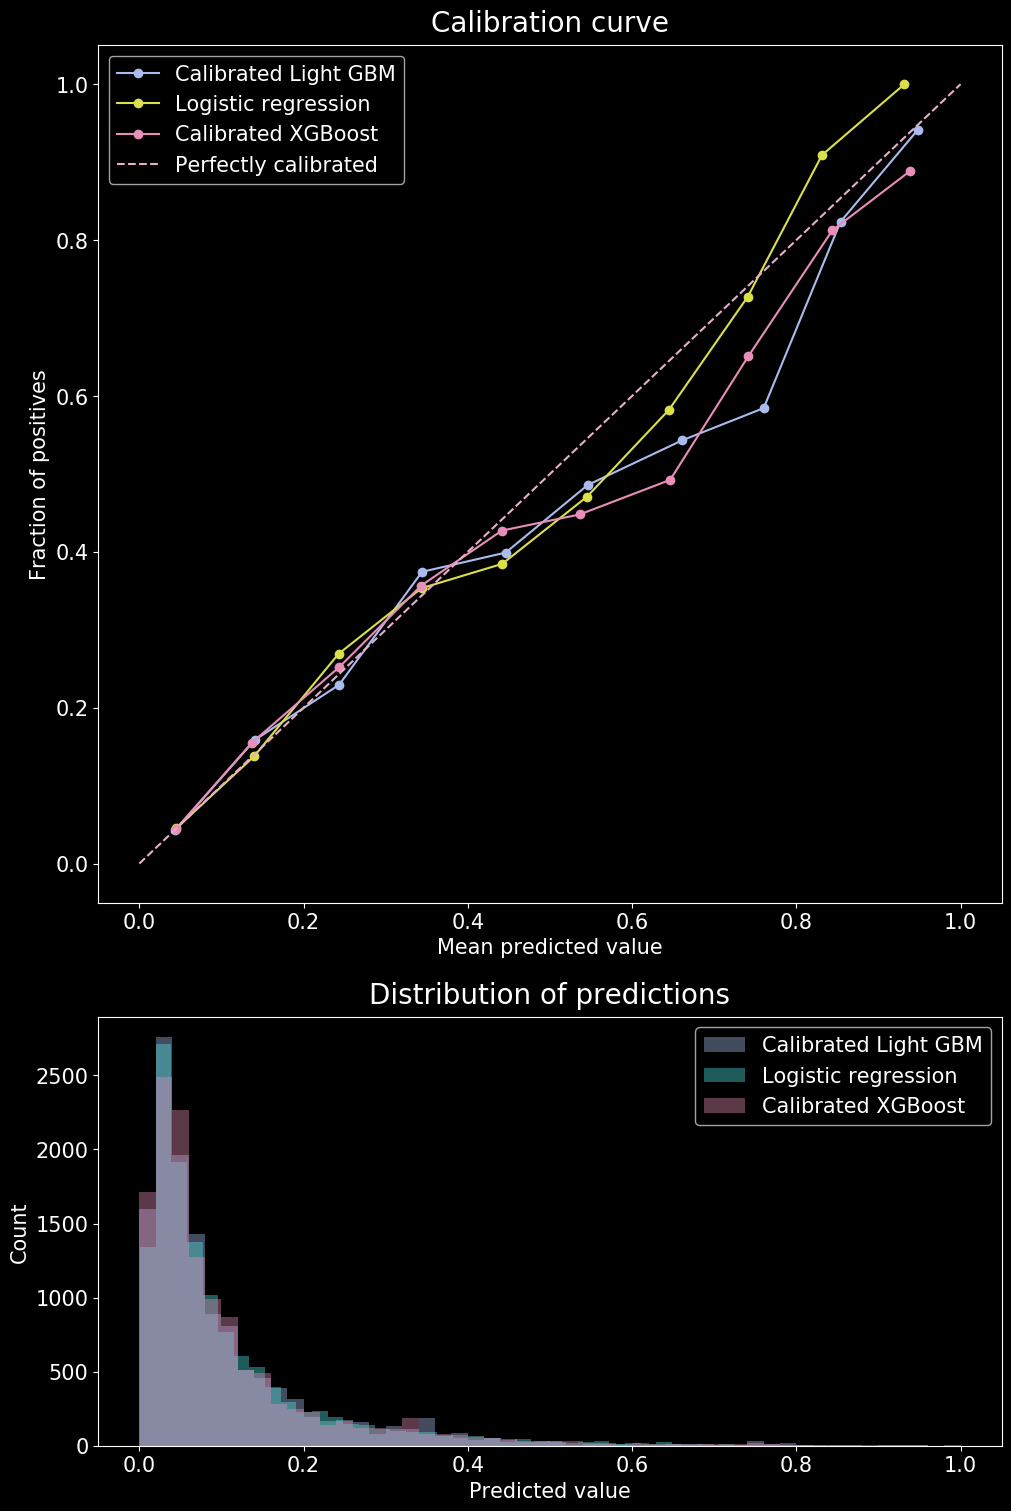

In [86]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, "-o", color='#e88fb9', label='Calibrated XGBoost')
ax1.plot(mean_predicted_value_rf, fraction_of_positives_rf, "-o", color='#16e01d', label='Calibrated Random Forest')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_xgb[:,1], color='#e88fb9', label='Calibrated XGBoost', kde=False, ax=ax2)
sns.distplot(y_pred_rf[:, 1], color='#16e01d', label='Calibrated Random Forest', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve2.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [87]:
print("The log loss of the non-penalty model with Logistic Regression is: " + str(log_loss(y_true_test_lr, y_pred_lr[:,1])))
print("The ROC AUC score of the non-penalty model with Logistic Regression is: " +str(roc_auc_score(y_true_test_lr,
                                                                                                    y_pred_lr[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is:', mcfadden_r2(y_true_test_lr,
                                                                                                    y_pred_lr[:,1]))
print('The Brier score of the non-penalty model with Logistic Regression is:',brier_score_loss(y_true_test_lr, y_pred_lr[:,1],
                                                                                         pos_label=y_true_test_lr.max()))

The log loss of the non-penalty model with Logistic Regression is: 0.2846301821087627
The ROC AUC score of the non-penalty model with Logistic Regression is: 0.7815561430511246
The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is: 0.15864339709380737
The Brier score of the non-penalty model with Logistic Regression is: 0.08214078482621053


In [88]:
print("The log loss of the non-penalty model with LightGBM is: " + str(log_loss(y_test_lgbm, y_pred_lgbm)))
print("The ROC AUC score of the non-penalty model with LightGBM is: " +str(roc_auc_score(y_test_lgbm, y_pred_lgbm[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is:', mcfadden_r2(y_test_lgbm, y_pred_lgbm[:,1]))
print('The Brier score of the non-penalty model with LightGBM is:',brier_score_loss(y_test_lgbm, y_pred_lgbm[:,1],
                                                                                    pos_label=y_test_lgbm.max()))

The log loss of the non-penalty model with LightGBM is: 0.28153316520818134
The ROC AUC score of the non-penalty model with LightGBM is: 0.790090043643302
The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is: 0.167798067899662
The Brier score of the non-penalty model with LightGBM is: 0.08147355595405839


In [89]:
print("The log loss of the non-penalty model with XGBoost is: " + str(log_loss(y_test_xgb, y_pred_xgb)))
print("The ROC AUC score of the non-penalty model with XGBoost is: " +str(roc_auc_score(y_test_xgb, y_pred_xgb[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with XGBoost is:', mcfadden_r2(y_test_xgb, y_pred_xgb[:,1]))
print('The Brier score of the non-penalty model with XGBoost is:',brier_score_loss(y_test_xgb, y_pred_xgb[:,1],
                                                                                    pos_label=y_test_xgb.max()))

The log loss of the non-penalty model with XGBoost is: 0.2837518483056879
The ROC AUC score of the non-penalty model with XGBoost is: 0.7912086300834453
The McFaddens Pseudo R-squared of the non-penalty model with XGBoost is: 0.16123972029220346
The Brier score of the non-penalty model with XGBoost is: 0.0815620315378921


In [ ]:
print("The log loss of the non-penalty model with Random Forest is: " + str(log_loss(y_true_test_rf, y_pred_rf)))
print("The ROC AUC score of the non-penalty model with Random Forest is: " +str(roc_auc_score(y_true_test_rf, y_pred_rf[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is:', mcfadden_r2(y_true_test_rf,
                                                                                                   y_pred_rf[:,1]))
print('The Brier score of the non-penalty model with Random Forest is:',brier_score_loss(y_true_test_rf, y_pred_rf[:,1],
                                                                                    pos_label=y_true_test_rf.max()))

Same calculation for penalty shots

In [91]:
# logistic regression
y_true_test_lr_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_lr_p, y_pred_lr_p[:,1], n_bins=10)
# lightGBM
fraction_of_positives_lgbm_p, mean_predicted_value_lgbm_p = calibration_curve(y_penalty_test_lgbm, y_pred_lgbm_p[:, 1],
                                                                              n_bins=10)
# XGBoost
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test_xgb, y_pred_xgb_p[:, 1],
                                                                            n_bins=10)
# Random Forest
y_true_test_rf_p = y_p_test_rf
fraction_of_positives_rf_p, mean_predicted_value_rf_p = calibration_curve(y_true_test_rf_p, y_pred_rf_p[:,1], n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

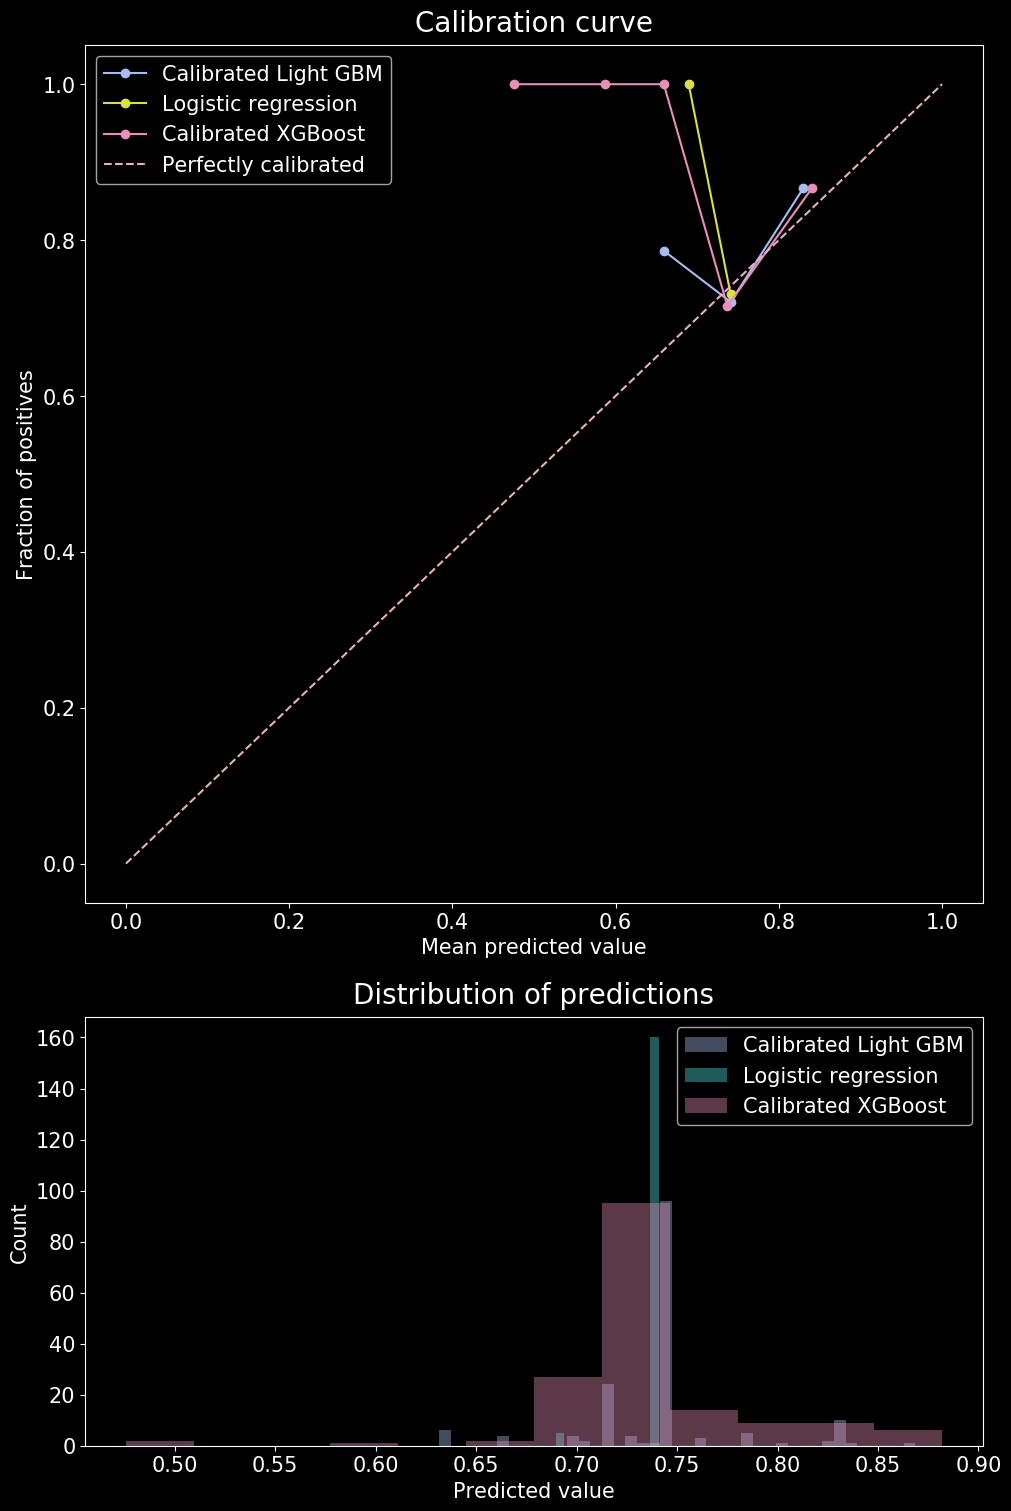

In [93]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm_p, fraction_of_positives_lgbm_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#e88fb9', label='Calibrated XGBoost')
ax1.plot(mean_predicted_value_rf_p, fraction_of_positives_rf_p, "-o", color='#16e01d', label='Calibrated Random Forest')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr_p[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_xgb_p[:, 1], color='#e88fb9', label='Calibrated XGBoost', kde=False, ax=ax2)
sns.distplot(y_pred_rf_p[:, 1], color='#16e01d', label='Calibrated Random Forest', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [94]:
print("The log loss of the penalty model with Logistic Regresion is: " + str(log_loss(y_true_test_lr_p, y_pred_lr_p[:,1])))
print("The ROC AUC score of the penalty model with Logistic Regresion is: " +str(roc_auc_score(y_true_test_lr_p,
                                                                                               y_pred_lr_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is:', mcfadden_r2(y_true_test_lr_p,
                                                                                                y_pred_lr_p[:,1]))
print('The Brier score of the penalty model with Logistic Regresion is:',brier_score_loss(y_true_test_lr_p, y_pred_lr_p[:,1],
                                                                         pos_label=y_true_test_lr_p.max()))

The log loss of the penalty model with Logistic Regresion is: 0.5758706160394315
The ROC AUC score of the penalty model with Logistic Regresion is: 0.47950819672131145
The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is: -0.0038012394860251764
The Brier score of the penalty model with Logistic Regresion is: 0.19357847977312514


In [95]:
print("The log loss of the penalty model with LightGBM is: " + str(log_loss(y_penalty_test_lgbm, y_pred_lgbm_p)))
print("The ROC AUC score of the penalty model with LightGBM is: " +str(roc_auc_score(y_penalty_test_lgbm,
                                                                                  y_pred_lgbm_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with LightGBM is:', mcfadden_r2(y_penalty_test_lgbm,
                                                                                                     y_pred_lgbm_p[:,1]))
print('The Brier score of the penalty model with LightGBM is:',brier_score_loss(y_penalty_test_lgbm, y_pred_lgbm_p[:,1], 
                                                           pos_label=y_penalty_test_lgbm.max()))

The log loss of the penalty model with LightGBM is: 0.5769013805862958
The ROC AUC score of the penalty model with LightGBM is: 0.48436904308044226
The McFaddens Pseudo R-squared of the penalty model with LightGBM is: -0.005597967259490577
The Brier score of the penalty model with LightGBM is: 0.19416712504433387


In [96]:
print("The log loss of the penalty model with XGBoost is: " + str(log_loss(y_penalty_test_xgb, y_pred_xgb_p)))
print("The ROC AUC score of the penalty model with XGBoost is: " +str(roc_auc_score(y_penalty_test_xgb, 
                                                                                  y_pred_xgb_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with XGBoost is:', mcfadden_r2(y_penalty_test_xgb,
                                                                                           y_pred_xgb_p[:,1]))
print('The Brier score of the penalty model with XGBoost is:',brier_score_loss(y_penalty_test_xgb, y_pred_xgb_p[:,1], 
                                                           pos_label=y_penalty_test_xgb.max()))

The log loss of the penalty model with XGBoost is: 0.5809962176885552
The ROC AUC score of the penalty model with XGBoost is: 0.5074342356080823
The McFaddens Pseudo R-squared of the penalty model with XGBoost is: -0.01273568612247189
The Brier score of the penalty model with XGBoost is: 0.19613771713290323


In [ ]:
print("The log loss of the non-penalty model with Random Forest is: " + str(log_loss(y_true_test_rf_p, y_pred_rf_p)))
print("The ROC AUC score of the non-penalty model with Random Forest is: " +str(roc_auc_score(y_true_test_rf_p,
                                                                                             y_pred_rf_p[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is:', mcfadden_r2(y_true_test_rf_p,
                                                                                                   y_pred_rf_p[:,1]))
print('The Brier score of the non-penalty model with Random Forest is:',brier_score_loss(y_true_test_rf_p, y_pred_rf_p[:,1],
                                                                                    pos_label=y_true_test_rf_p.max()))

# Save models

In [97]:
dump(logistic_regression_npp, os.path.join(cwd, 'models', 'lr_model_pass.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_pass.joblib']

In [98]:
dump(logistic_regression_npo, os.path.join(cwd, 'models', 'lr_model_other.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_other.joblib']

In [99]:
dump(logistic_regression_p, os.path.join(cwd, 'models', 'lr_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_penalty.joblib']

In [101]:
dump(searchcv_lgbm.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model.joblib']

In [103]:
dump(searchcv_lgbm_p.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model_penalty.joblib']

In [104]:
dump(searchcv_xgb.best_estimator_, os.path.join(cwd, 'models', 'xgb_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model.joblib']

In [105]:
dump(searchcv_xgb_p.best_estimator_, os.path.join(cwd, 'models', 'xgb_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model_penalty.joblib']

In [ ]:
dump(searchcv_rf_npp.best_estimator_, os.path.join(cwd, 'models', 'rf_model_pass.joblib'))

In [ ]:
dump(searchcv_rf_npo.best_estimator_, os.path.join(cwd, 'models', 'rf_model_other.joblib'))

In [ ]:
dump(searchcv_rf_p.best_estimator_, os.path.join(cwd, 'models', 'rf_model_penalty.joblib'))

# Save data

In [106]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [107]:
x_npp_train3['goal'] = y_npp_train
x_npp_train3['split'] = 'train'
x_npp_test3['goal'] = y_npp_test
x_npp_test3['split'] = 'test'
df_pass = pd.concat([x_npp_train3, x_npp_test3])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_pass.parquet'))

x_npo_train3['goal'] = y_npo_train
x_npo_train3['split'] = 'train'
x_npo_test3['goal'] = y_npo_test
x_npo_test3['split'] = 'test'
df_other = pd.concat([x_npo_train3, x_npo_test3])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_other.parquet'))

x_p_train3['goal'] = y_p_train
x_p_train3['split'] = 'train'
x_p_test3['goal'] = y_p_test
x_p_test3['split'] = 'test'
df_penalty = pd.concat([x_p_train3, x_p_test3])
df_penalty = df_penalty.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty.reset_index(drop=True, inplace=True)
df_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_penalty.parquet'))

In [110]:
# reload shot dataset for ids
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty2 = df2[mask_penalty].copy()
df_non_penalty2 = df2[~mask_penalty].copy()
df_penalty2 = df_penalty2[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
df_non_penalty2 = df_non_penalty2[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [113]:
X_train_lgbm['goal'] = y_train_lgbm
X_train_lgbm['split'] = 'train'
X_test_lgbm['goal'] = y_test_lgbm
X_test_lgbm['split'] = 'test'
df_lgbm = pd.concat([X_train_lgbm, X_test_lgbm])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty2.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty2, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))

X_penalty_train_lgbm['goal'] = y_penalty_train_lgbm
X_penalty_train_lgbm['split'] = 'train'
X_penalty_test_lgbm['goal'] = y_penalty_test_lgbm
X_penalty_test_lgbm['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train_lgbm, X_penalty_test_lgbm])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty2.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty2, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm_penalty.parquet'))

In [ ]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df3.shot_type_name=='penalty')
df_penalty3 = df3[mask_penalty].copy()
df_non_penalty3 = df3[~mask_penalty].copy()
df_penalty3 = df_penalty3[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
df_non_penalty3 = df_non_penalty3[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [ ]:
X_train_xgb['goal'] = y_train_xgb
X_train_xgb['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train_xgb, X_test])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty3.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty3, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb.parquet'))

X_penalty_train_xgb['goal'] = y_penalty_train_xgb
X_penalty_train_xgb['split'] = 'train'
X_penalty_test_xgb['goal'] = y_penalty_test
X_penalty_test_xgb['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train_xgb, X_penalty_test_xgb])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty3.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty3, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb_penalty.parquet'))

In [ ]:
# reload shot dataset for ids
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4 = df4[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [ ]:
x_npp_train_rf['goal'] = y_npp_train_rf
x_npp_train_rf['split'] = 'train'
x_npp_test_rf['goal'] = y_npp_test_rf
x_npp_test_rf['split'] = 'test'
df_pass4 = pd.concat([x_npp_train_rf, x_npp_test_rf])
df_pass4 = df_pass4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_pass4.reset_index(drop=True, inplace=True)
df_pass4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_pass.parquet'))

x_npo_train_rf['goal'] = y_npo_train_rf
x_npo_train_rf['split'] = 'train'
x_npo_test_rf['goal'] = y_npo_test_rf
x_npo_test_rf['split'] = 'test'
df_other4 = pd.concat([x_npo_train_rf, x_npo_test_rf])
df_other4 = df_other4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_other4.reset_index(drop=True, inplace=True)
df_other4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_other.parquet'))

x_p_train_rf['goal'] = y_p_train_rf
x_p_train_rf['split'] = 'train'
x_p_test_rf['goal'] = y_p_test_rf
x_p_test_rf['split'] = 'test'
df_penalty4 = pd.concat([x_p_train_rf, x_p_test_rf])
df_penalty4 = df_penalty4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty4.reset_index(drop=True, inplace=True)
df_penalty4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_penalty.parquet'))